## Subject-level analysis pipeline for "*Emotionen im Griff*" EDA-data 
<font color='blue'>Version 1.0 (2023-07-19)<br></font> Dr. Torsten Wüstenberg (CNSR)

**Aim:** compute condition specific skin coductance response parameters

**Gereral analysis steps:**

1. *Specify and load data for analysis*
2. *Data pruning*
3. *Detect events*
4. *EDA-signal decomposition in tonic (SCL) and phasic (SCR) responses*
5. *Segment data into epochs and compute condition specific SCR-ampliture & -rise time*
8. *Writing results to excel sheet*

## Preparations ---------------------------------------------------------------------¶

### Import libraries
The analysis pipeline is based on the following libraries. In case of an error in the execution of this cell, probably one or more of the libraries is not installed. In this case, start a terminal in **ANACONDS.NAVIGATOR** *Environments>Terminal* and install the library in question using the command </br><font color='red'>*pip install [library name]*</font>.

### Load libraries
#### General libraries

In [ ]:
import warnings  # switch of pandas and mne warnings

warnings.simplefilter(action="ignore")
import matplotlib.pyplot as plt  # general plotting functions

%matplotlib qt
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
import os
import neurokit2 as nk

### Function for graphical data pruning

In [ ]:
global xLims, yLims


def ax_lims_change(event_ax):
    global xLims, yLims
    xLims = event_ax.get_xlim()
    yLims = event_ax.get_ylim()

## Pipeline -------------------------------------------------------------------

## 1. Specify and load data for analysis

**Load configuration file**

In [ ]:
conf = pd.read_excel("/Users/twu/Data/EmPra/HandyPic/StimulilisteVideo.xlsx")
cond = []
for ii in range(0, len(conf)):
    if conf["Bedingung"][ii] == 1 and conf["Valenz"][ii] == "positiv":
        cond.append("PCgrossPOS")
    if conf["Bedingung"][ii] == 2 and conf["Valenz"][ii] == "positiv":
        cond.append("PCkleinPOS")
    if conf["Bedingung"][ii] == 3 and conf["Valenz"][ii] == "positiv":
        cond.append("HandyPOS")
    if conf["Bedingung"][ii] == 1 and conf["Valenz"][ii] == "negativ":
        cond.append("PCgrossNEG")
    if conf["Bedingung"][ii] == 2 and conf["Valenz"][ii] == "negativ":
        cond.append("PCkleinNEG")
    if conf["Bedingung"][ii] == 3 and conf["Valenz"][ii] == "negativ":
        cond.append("HandyNEG")

# <font color='red'>Please start in the cell below with a new subject/anlysis!</font></br>
**Specify data file and SID**

In [ ]:
fname = "/Users/twu/Data/EmPra/HandyPic/52004.txt"
fnameParts = fname.split(os.sep)
sid = fnameParts[-1][0:-4]
print("SID: " + sid)

**Load data file**

In [ ]:
data, header = nk.read_bitalino(fname)

## 2. Data pruning
**Show LUX-sensor data.**</br>
<font color='red'>**Please select events by means of the zoom tool!**</font>

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
ax.plot(data[["LUX"]], linewidth=0.5)
ax.callbacks.connect("xlim_changed", ax_lims_change)
fig.show()

**Prune data**

In [ ]:
pdata = data[int(xLims[0]) : int(xLims[1])]
pdata.index = np.arange(len(pdata))
print(f"Data cutted at {int(xLims[0])} / {int(xLims[1])}")

## 3. Detect events
**Show pruned LUX-sensor data.**</br>
<font color='red'>**Please define signal threshold for event detection by means of the zoom tool!**</font>

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
ax.plot(pdata[["LUX"]], linewidth=0.5)
ax.callbacks.connect("ylim_changed", ax_lims_change)
fig.show()

**Detect events and show onsets in relation to LUX-sensor data.**

In [ ]:
events = nk.events_find(
    pdata["LUX"],
    threshold=np.mean(yLims),
    threshold_keep="above",
    event_conditions=cond,
    duration_min=1000,
)
plot = nk.events_plot(events, pdata["LUX"])
print(f"{len(events['onset'])} events found for threshold {np.mean(yLims)}")

## 4. EDA-signal decomposition in tonic (SCL) and phasic (SCR) responses

In [ ]:
data_clean, info = nk.eda_process(pdata["EDA"], sampling_rate=header["sampling_rate"])

**Show EDA-signal components.**

In [ ]:
plt.plot(data_clean["EDA_Clean"])
plt.plot(data_clean["EDA_Tonic"])
plt.plot(data_clean["EDA_Phasic"])
plt.show()

## 5. Segment data and compute condition specific SCR-ampliture & -rise time
### **SCR-parameters:**
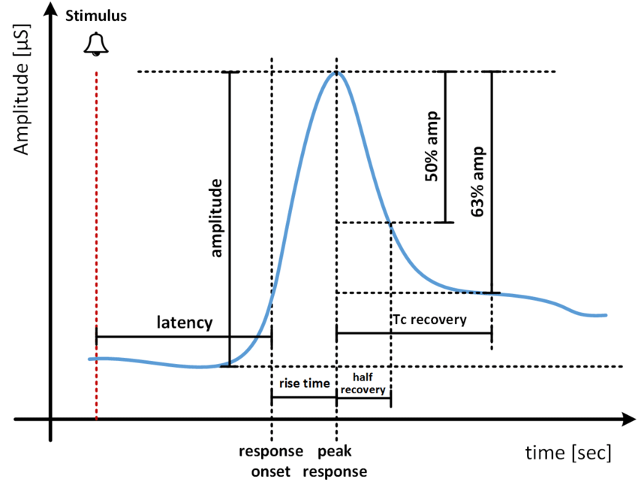

**Compute parameters, show results and save figure**

In [ ]:
resTable = pd.read_excel("/Users/twu/Data/EmPra/HandyPic_EDA_results_July2023.xlsx")

row = {
    "SID": sid,
    "HandyPOS_ampSCR": np.nan,
    "HandyNEG_ampSCR": np.nan,
    "PCgrossPOS_ampSCR": np.nan,
    "PCgrossNEG_ampSCR": np.nan,
    "PCkleinPOS_ampSCR": np.nan,
    "PCkleinNEG_ampSCR": np.nan,
    "HandyPOS_riseSCR": np.nan,
    "HandyNEG_riseSCR": np.nan,
    "PCgrossPOS_riseSCR": np.nan,
    "PCgrossNEG_riseSCR": np.nan,
    "PCkleinPOS_riseSCR": np.nan,
    "PCkleinNEG_riseSCR": np.nan,
}

cc = ["PCkleinPOS", "PCkleinNEG", "PCgrossPOS", "PCgrossNEG", "HandyPOS", "HandyNEG"]
epochs = nk.epochs_create(
    data_clean,
    events,
    sampling_rate=header["sampling_rate"],
    epochs_start=0,
    epochs_end=6,
)
time = epochs["1"].index
ek = list(epochs.keys())

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(6)

for jj in cc:
    counter = 0
    meanResp = np.zeros((len(epochs["1"]), 20))
    for ii in range(len(ek)):
        if events["condition"][ii] == jj:
            meanResp[:, counter] = epochs[ek[ii]]["EDA_Phasic"]
            meanResp[:, counter] = meanResp[:, counter] - meanResp[0, counter]
            counter += 1

    meanResp = meanResp[:, 0:counter]
    mR = np.mean(meanResp, axis=1)
    vR = np.std(meanResp, axis=1) / np.sqrt(counter)
    ax.fill_between(time, mR - vR, mR + vR, alpha=0.2)
    if np.max(mR) > 0:
        ax.plot(time, mR, label=jj)
    else:
        ax.plot(time, mR, linestyle="dashed", label=jj)

    if np.max(mR) > 0:
        row[jj + "_ampSCR"] = np.max(mR)
        row[jj + "_riseSCR"] = time[mR == np.max(mR)].to_numpy()[0]

lim = ax.get_ylim()
ax.fill_between(
    [0, 4],
    [lim[0], lim[0]],
    [lim[1], lim[1]],
    color=(0, 0, 0),
    alpha=0.1,
    label="Stim period",
)
ax.plot([0, 6], [0, 0], "k")
ax.legend(loc="upper right")
ax.set_xlim([0, 6])
ax.set_ylim(lim)
ax.set_xlabel("Time (sec)")
ax.set_ylabel("SCR")
ax.set_title("Vp #" + sid)
plt.show()
plt.savefig(sid + ".png")

## 6. Writing results to excel sheet

In [ ]:
resTable = pd.concat([resTable, pd.DataFrame([row])])
resTable.to_excel(
    "/Users/twu/Data/EmPra/HandyPic_EDA_results_July2023.xlsx", index=None
)
resTable